
프로젝트 : CutMix 또는 Mixup 비교 실험

- 목표 : augmentation의 적용 유무에 따른 ResNet50 분류기의 견종 분류 정확도 성능 비교

- 비교대상

1. Augmentation을 적용하지 않은 basic 데이터셋
2. Augmentation을 적용한 데이터셋
3. Augmentation과 CutMix를 적용한 데이터셋
4. Augmentation과 Mixup을 적용한 데이터셋

In [4]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

print(tf.__version__)
print(np.__version__)

2.6.5
1.19.5


In [5]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

텐서플로우 데이터셋 중 standford_dogs 로드 

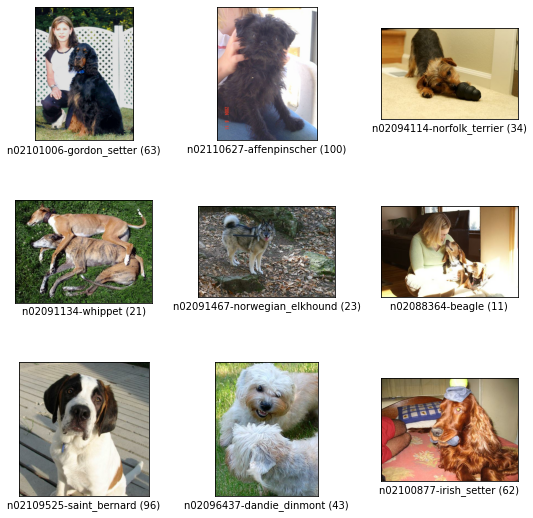

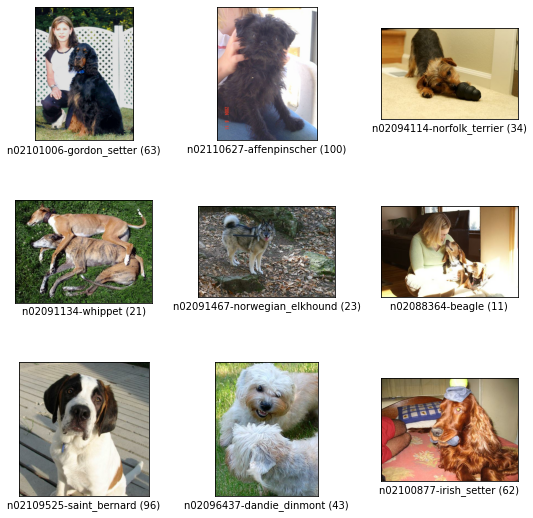

In [6]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

tfds.show_examples(ds_train, ds_info)

In [7]:
ds_info

tfds.core.DatasetInfo(
    name='stanford_dogs',
    full_name='stanford_dogs/0.2.0',
    description="""
    The Stanford Dogs dataset contains images of 120 breeds of dogs from around
    the world. This dataset has been built using images and annotation from
    ImageNet for the task of fine-grained image categorization. There are
    20,580 images, out of which 12,000 are used for training and 8580 for
    testing. Class labels and bounding box annotations are provided
    for all the 12,000 images.
    """,
    homepage='http://vision.stanford.edu/aditya86/ImageNetDogs/main.html',
    data_path='/home/bckang/tensorflow_datasets/stanford_dogs/0.2.0',
    file_format=tfrecord,
    download_size=778.12 MiB,
    dataset_size=744.72 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=120),
        'objects': Sequence({
         

In [8]:
num_classes = ds_info.features["label"].num_classes
num_classes

120

Augmentation, CutMix, MixUp

In [9]:
# normalize, resize
def normalize_and_resize_img(image, label): 
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

- augmentation

In [10]:
# augmentation
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1) # brightness로 변한 image 텐서 값을 0~1 사이로 맞춘다.
    return image, label

CutMix

In [11]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

In [12]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

In [13]:
# mix two labels
def mix_2_labels(image_a, image_b, label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

In [14]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(image_a, image_b, label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

MixUp

In [15]:
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

In [16]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

적용하기

In [17]:
def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

In [18]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, 
                               with_aug=False, with_cutmix=False, with_mixup=False):
    
    # image normalize, resize
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2 # 병렬 처리
    )
    if not is_test and with_aug: # train에 augmentation 적용
        ds = ds.map(
            augment,
            num_parallel_calls=2
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix: # train에 cutmix 적용
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup: # train에 mixup 적용
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

resnet50 모델 불러오기

1. Augmentation을 적용하지 않은 basic 데이터셋

In [19]:
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False, # 마지막 FC layer 포함 여부
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

2. Augmentation을 적용한 데이터셋

In [20]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

3. Augmentation과 CutMix를 적용한 데이터셋

In [21]:
aug_cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

4. Augmentation과 mixup을 적용한 데이터셋

In [22]:
aug_mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [23]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_aug=True, with_mixup=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

Train

In [24]:
EPOCH = 20

In [25]:
resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

/home/bckang/.pyenv/versions/3.8.5/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/20
750/750 [==============================] - 95s 118ms/step - loss: 2.2356 - accuracy: 0.4437 - val_loss: 3.2011 - val_accuracy: 0.2380
Epoch 2/20
750/750 [==============================] - 89s 118ms/step - loss: 0.7871 - accuracy: 0.7783 - val_loss: 1.1784 - val_accuracy: 0.6533
Epoch 3/20
750/750 [==============================] - 89s 118ms/step - loss: 0.2941 - accuracy: 0.9308 - val_loss: 1.0165 - val_accuracy: 0.7055
Epoch 4/20
750/750 [==============================] - 89s 118ms/step - loss: 0.1265 - accuracy: 0.9795 - val_loss: 0.9728 - val_accuracy: 0.7221
Epoch 5/20
750/750 [==============================] - 89s 118ms/step - loss: 0.0568 - accuracy: 0.9947 - val_loss: 0.9340 - val_accuracy: 0.7394
Epoch 6/20
750/750 [==============================] - 89s 118ms/step - loss: 0.0228 - accuracy: 0.9991 - val_loss: 0.9396 - val_accuracy: 0.7415
Epoch 7/20
750/750 [==============================] - 89s 118ms/step - loss: 0.0152 - accuracy: 0.9994 - val_loss: 0.9479 - val_ac

In [26]:
aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 94s 120ms/step - loss: 2.2742 - accuracy: 0.4269 - val_loss: 3.1648 - val_accuracy: 0.2465
Epoch 2/20
750/750 [==============================] - 90s 120ms/step - loss: 1.0018 - accuracy: 0.7080 - val_loss: 1.1694 - val_accuracy: 0.6559
Epoch 3/20
750/750 [==============================] - 90s 120ms/step - loss: 0.5943 - accuracy: 0.8287 - val_loss: 1.1888 - val_accuracy: 0.6540
Epoch 4/20
750/750 [==============================] - 90s 120ms/step - loss: 0.3371 - accuracy: 0.9120 - val_loss: 1.1126 - val_accuracy: 0.6870
Epoch 5/20
750/750 [==============================] - 90s 120ms/step - loss: 0.2131 - accuracy: 0.9495 - val_loss: 0.9884 - val_accuracy: 0.7144
Epoch 6/20
750/750 [==============================] - 90s 120ms/step - loss: 0.1352 - accuracy: 0.9724 - val_loss: 0.9389 - val_accuracy: 0.7352
Epoch 7/20
750/750 [==============================] - 90s 120ms/step - loss: 0.0908 - accuracy: 0.9835 - val_loss: 0.9978 - val_ac

In [27]:
aug_cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug_cutmix = aug_resnet50.fit(
    ds_train_cutmix, # augmentation, cutmix 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 102s 130ms/step - loss: 2.4058 - accuracy: 0.6467 - val_loss: 1.5271 - val_accuracy: 0.6083
Epoch 2/20
750/750 [==============================] - 98s 130ms/step - loss: 2.2539 - accuracy: 0.6662 - val_loss: 1.1815 - val_accuracy: 0.6868
Epoch 3/20
750/750 [==============================] - 98s 130ms/step - loss: 2.1688 - accuracy: 0.6921 - val_loss: 1.1896 - val_accuracy: 0.6903
Epoch 4/20
750/750 [==============================] - 98s 131ms/step - loss: 2.0940 - accuracy: 0.7113 - val_loss: 1.1959 - val_accuracy: 0.6883
Epoch 5/20
750/750 [==============================] - 98s 130ms/step - loss: 2.0363 - accuracy: 0.7286 - val_loss: 1.3261 - val_accuracy: 0.6566
Epoch 6/20
750/750 [==============================] - 98s 131ms/step - loss: 2.0017 - accuracy: 0.7311 - val_loss: 1.3361 - val_accuracy: 0.6551
Epoch 7/20
750/750 [==============================] - 98s 130ms/step - loss: 1.9713 - accuracy: 0.7334 - val_loss: 1.2522 - val_a

In [28]:
aug_mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug_mixup = aug_resnet50.fit(
    ds_train_mixup, # augmentation, mixup 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 102s 132ms/step - loss: 1.9134 - accuracy: 0.8264 - val_loss: 1.4296 - val_accuracy: 0.6688
Epoch 2/20
750/750 [==============================] - 99s 132ms/step - loss: 1.8663 - accuracy: 0.8328 - val_loss: 1.5992 - val_accuracy: 0.6257
Epoch 3/20
750/750 [==============================] - 99s 132ms/step - loss: 1.8290 - accuracy: 0.8383 - val_loss: 1.3990 - val_accuracy: 0.6709
Epoch 4/20
750/750 [==============================] - 99s 132ms/step - loss: 1.8077 - accuracy: 0.8407 - val_loss: 1.6063 - val_accuracy: 0.6301
Epoch 5/20
750/750 [==============================] - 99s 132ms/step - loss: 1.8021 - accuracy: 0.8454 - val_loss: 1.3882 - val_accuracy: 0.6660
Epoch 6/20
750/750 [==============================] - 99s 132ms/step - loss: 1.7687 - accuracy: 0.8514 - val_loss: 1.3101 - val_accuracy: 0.6920
Epoch 7/20
750/750 [==============================] - 99s 132ms/step - loss: 1.7674 - accuracy: 0.8497 - val_loss: 1.4857 - val_a

시각화

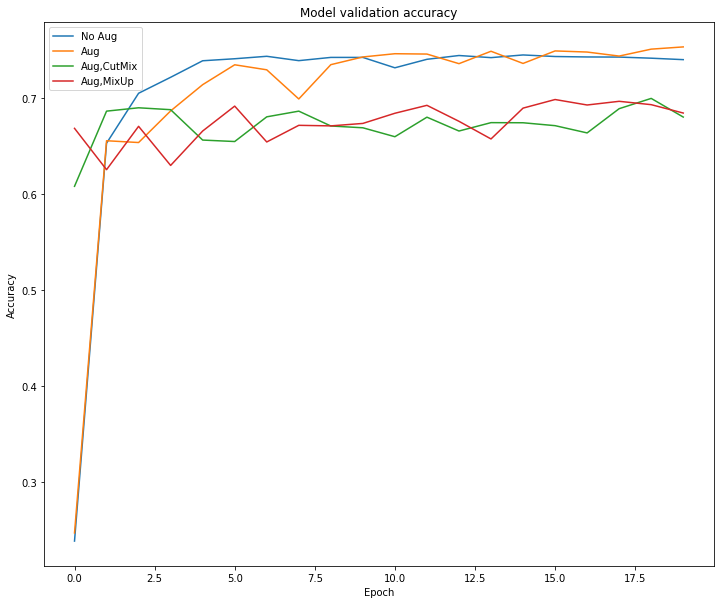

In [29]:
plt.figure(figsize=(12, 10))

plt.plot(history_resnet50_no_aug.history['val_accuracy'])
plt.plot(history_resnet50_aug.history['val_accuracy'])
plt.plot(history_resnet50_aug_cutmix.history['val_accuracy'])
plt.plot(history_resnet50_aug_mixup.history['val_accuracy'])
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Aug', 'Aug','Aug,CutMix','Aug,MixUp'])
plt.show()

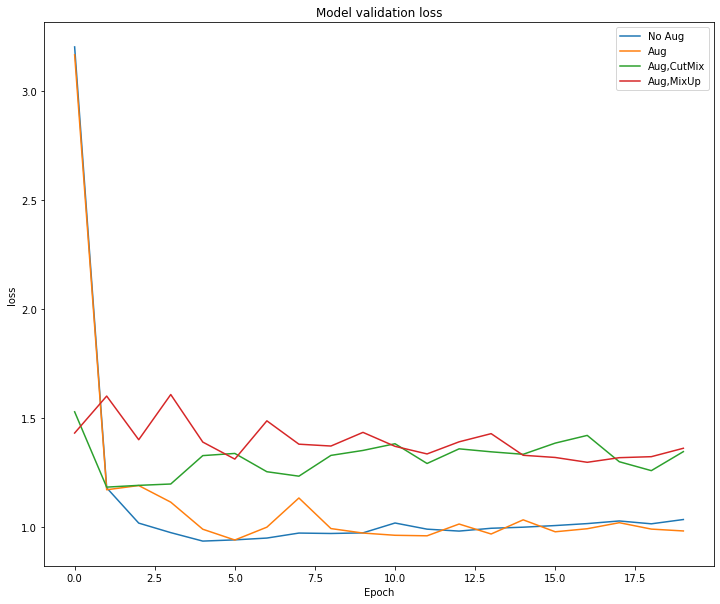

In [30]:
plt.figure(figsize=(12, 10))

plt.plot(history_resnet50_no_aug.history['val_loss'])
plt.plot(history_resnet50_aug.history['val_loss'])
plt.plot(history_resnet50_aug_cutmix.history['val_loss'])
plt.plot(history_resnet50_aug_mixup.history['val_loss'])
plt.title('Model validation loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['No Aug', 'Aug','Aug,CutMix','Aug,MixUp'])
plt.show()

# 회고
EPOCH의 횟수가 낮아서 도출된 결과로 전체를 파악하기는 어려울듯 함<br>
20회 EPOCH으로는 Augmentation만 했을때와 Augmentation이 없을때 비슷한 Loss유을 보이는 듯 함<br>
Mix-Up과 CutMix는 데이터를 보완하는 목적보다는 검증의 의미로 해석해보았음.<br>